<h1>Preprocessing PBMCs T Panel</h1>

In [1]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

/home/rossco/immunova/env/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/rossco/immunova/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
texp = FCSExperiment.objects(experiment_id='PD_T_PBMCs').get()

In [3]:
texp.list_samples()

['142-09_pbmc_t',
 '165-09_pbmc_t',
 '175-09_pbmc_t',
 '210-14_pbmc_t',
 '239-02_pbmc_t',
 '239-04_pbmc_t',
 '251-08_pbmc_t',
 '254-04_pbmc_t',
 '254-05_pbmc_t',
 '255-04_pbmc_t',
 '255-05_pbmc_t',
 '264-02_pbmc_t',
 '273-01_pbmc_t',
 '276-01_pbmc_t',
 '286-03_pbmc_t',
 '286-04_pbmc_t',
 '294-02_pbmc_t',
 '294-03_pbmc_t',
 '298-01_pbmc_t',
 '305-01_pbmc_t',
 '305-02_pbmc_t',
 '305-03_pbmc_t',
 '306-01_pbmc_t',
 '308-01_pbmc_t',
 '308-02R_pbmc_t',
 '308-03R_pbmc_t',
 '308-04_pbmc_t',
 '310-01_pbmc_t',
 '315-01_pbmc_t',
 '315-02_pbmc_t',
 '316-01_pbmc_t',
 '318-01_pbmc_t',
 '322-01_pbmc_t',
 '323-01_pbmc_t',
 '324-01_pbmc_t',
 '326-01_pbmc_t',
 '286-02_pbmc_t']

In [4]:
import os
from notebook.services.contents.filemanager import FileContentsManager as FCM
for x in texp.list_samples():
    notebook_fname = f'{x}.ipynb'
    if not os.path.exists(notebook_fname):
        FCM().new(path=notebook_fname)

<h2>Create a template</h2>

Like with the PDMCs we will look to isolate Live CD3+ T cells. The objective of this process is to clean the sample as much as possible prior to cell classification and clustering.

In [6]:
t = Template(texp, '276-01_pbmc_t', include_controls=False)
t.clear_gates()

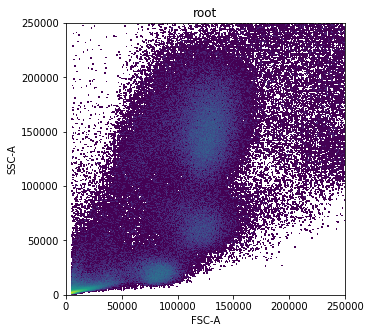

In [7]:
t.plotting.plot_population('root', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

**Boundary gate: simple static gate isolate lymphocytes and similar cells by forward and sideward scatter**

------ boundary ------
New population: cells
...proportion of total events: 0.396
...proportion of parent: 0.396
New population: debris
...proportion of total events: 0.604
...proportion of parent: 0.604
-----------------------


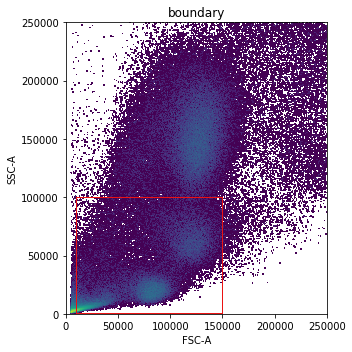

In [8]:
children = ChildPopulationCollection('geom')
children.add_population('cells', definition='+')
children.add_population('debris', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None,
             x_min=10000, y_min=1000, x_max=150000, y_max=100000)
t.create_gate(gate_name='boundary', 
              parent='root',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('boundary')

**CD3+ cells: density based gating to isolate all CD3+ cells**

We don't need to worry about monocytes at this point as they will be removed in the next gate as a result of CD14 being in the 'dump channel' (sharing the same fluorochrome as the Live/Dead stain)

------ CD3_gate ------
New population: CD3+
...proportion of total events: 0.057
...proportion of parent: 0.144
New population: CD3-
...proportion of total events: 0.339
...proportion of parent: 0.856
-----------------------


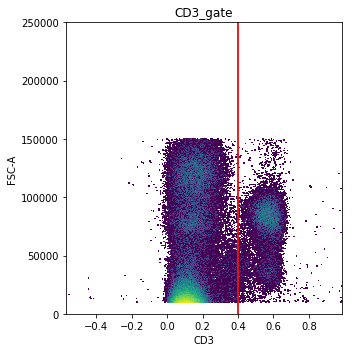

In [9]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD3+', definition='+')
children.add_population('CD3-', definition='-')
kwargs = dict(x='CD3', transform_x='logicle', kde_bw=0.05, low_memory=True, peak_threshold=0.05)
t.create_gate(gate_name='CD3_gate', 
              parent='cells',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
t.apply('CD3_gate')

**Live CD3+ cells: remove dead cells and anything in the dump channel by density gating**

------ live_gate ------
New population: dead
...proportion of total events: 0.005
...proportion of parent: 0.082
New population: live
...proportion of total events: 0.052
...proportion of parent: 0.918
-----------------------


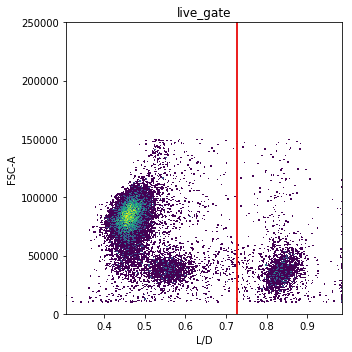

In [10]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('dead', definition='+')
children.add_population('live', definition='-')
kwargs = dict(x='L/D', transform_x='logicle', kde_bw=0.01, low_memory=False,
             ignore_double_pos=False, peak_threshold=0.01)
t.create_gate(gate_name='live_gate', 
              parent='CD3+',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
t.apply('live_gate')

**Single Live CD3+ T cells**

With the Live CD3+ T cells isolated, we can now exclude doublets by using forward scatter area vs forward scatter height, followed by forward scatter area vs sideward scatter width. For the first singlets gate want to find a single population roughly resembling a normal distribution with heavy tails, therefore here we will use the mixture model gate. For the second, we want to remove the long tail on the SSW axis created by large doublets, for this we can use density based gating again.

------ singlets1_gate ------
New population: singlets1
...proportion of total events: 0.044
...proportion of parent: 0.842
New population: doublets1
...proportion of total events: 0.008
...proportion of parent: 0.158
-----------------------


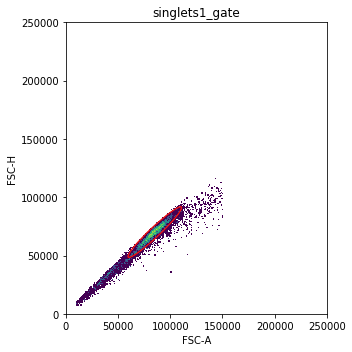

In [11]:
children = ChildPopulationCollection('geom')
children.add_population('singlets1', definition='+')
children.add_population('doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(75000, 60000),
             conf=0.99)
t.create_gate(gate_name='singlets1_gate', 
              parent='live',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets1_gate')

------ singlets2_gate ------
New population: doublets2
...proportion of total events: 0.002
...proportion of parent: 0.049
New population: single_Live_CD3+
...proportion of total events: 0.042
...proportion of parent: 0.951
-----------------------


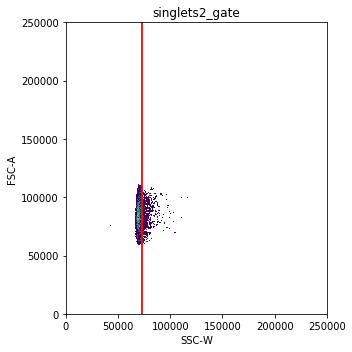

In [12]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('doublets2', definition='+')
children.add_population('single_Live_CD3+', definition='-')
kwargs = dict(x='SSC-W', transform_x=None, kde_bw=5000, low_memory=True,
             ignore_double_pos=False, peak_threshold=0.05)
t.create_gate(gate_name='singlets2_gate', 
              parent='singlets1',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets2_gate')

------ lymph_gate ------
New population: Lymphocytes
...proportion of total events: 0.040
...proportion of parent: 0.942
New population: other cells
...proportion of total events: 0.002
...proportion of parent: 0.058
-----------------------


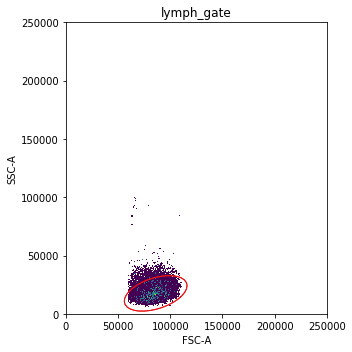

In [15]:
children = ChildPopulationCollection('geom')
children.add_population('Lymphocytes', definition='+')
children.add_population('other cells', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', target=(80000, 15000), k=2, conf=0.999, transform_x=None, transform_y=None)
t.create_gate(gate_name='lymph_gate', 
              parent='single_Live_CD3+',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('lymph_gate')

In [16]:
t.print_population_tree()

root
├── cells
│   ├── CD3+
│   │   ├── dead
│   │   └── live
│   │       ├── singlets1
│   │       │   ├── doublets2
│   │       │   └── single_Live_CD3+
│   │       │       ├── Lymphocytes
│   │       │       └── other cells
│   │       └── doublets1
│   └── CD3-
└── debris


**Save the template**

This template can now be saved to the database and then applied to the rest of the samples in the experiment.

In [17]:
t.save_new_template('PBMCt_Preprocessing', overwrite=True)

Overwriting existing gating template PBMCt_Preprocessing


True

<h2>Apply the preprocessing template to all samples</h2>

In [ ]:
samples = texp.list_samples()

In [ ]:
def apply_template(sample_id):
    print(f'------------------ {sample_id} ------------------')
    t = Template(texp, sample_id)
    t.load_template('PBMCt_Preprocessing')
    t.apply_many(apply_all=True, plot_outcome=True)
    return t

<h3>142-09</h3>

In [ ]:
sample_id = samples[0]
print(f'------------------ {sample_id} ------------------')
t = Template(texp, sample_id)
t.load_template('PBMCt_Preprocessing')
t.apply_many(apply_all=True, plot_outcome=True)

In [ ]:
t.clean('single_Live_CD3+')
t.save()

<h3>165-09</h3>

In [ ]:
sample_id = samples[1]
print(f'------------------ {sample_id} ------------------')
t = Template(texp, sample_id)
t.load_template('PBMCt_Preprocessing')
t.apply_many(apply_all=True, plot_outcome=True)

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[2])

I'm going to intervene here because I believe that another population has contaminated the singlet gates.

In [ ]:
t.plotting.plot_population('single_Live_CD3+', 'FSC-A', 'SSC-A', transforms={'x': None,
                                                                             'y': None})

In [ ]:
t.remove_gate('singlets2_gate', propagate=True)

In [ ]:
children = ChildPopulationCollection('geom')
children.add_population('single_Live_CD3+', definition='+')
children.add_population('doublets2', definition='-')
kwargs = dict(x='SSC-W', y='FSC-A', transform_x=None, transform_y=None, x_min=50000, x_max=80000,
             y_min=0, y_max=100000)
t.create_gate(gate_name='singlets2_gate', 
              parent='singlets1',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets2_gate')

In [ ]:
t.plotting.plot_population('single_Live_CD3+', 'FSC-A', 'SSC-A', transforms={'x': None,
                                                                             'y': None})

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[3])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
apply_template(samples[4])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
apply_template(samples[5])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[6])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[7])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[8])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[9])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[10])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[11])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[12])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[13])

In [ ]:
t.clean('single_Live_CD3+')
t.save(overwrite=True)

In [ ]:
t = apply_template(samples[14])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[15])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[16])

Unfortunately the bright Live staining creating a double positive seems to have confused the algorithm. Here I will intervene.

In [ ]:
t.print_population_tree()

In [ ]:
t.remove_gate('live_gate', propagate=True)

In [ ]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('dead', definition='+')
children.add_population('live', definition='-')
kwargs = dict(x='L/D', transform_x='logicle', q=0.95)
t.create_gate(gate_name='live_gate', 
              parent='CD3+',
              class_='Quantile',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
t.apply('live_gate')

I've replaced the density based gating with a quantile gate which gives much better results.

In [ ]:
children = ChildPopulationCollection('geom')
children.add_population('singlets1', definition='+')
children.add_population('doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(75000, 60000),
             conf=0.99)
t.create_gate(gate_name='singlets1_gate', 
              parent='live',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets1_gate')

children = ChildPopulationCollection('threshold_1d')
children.add_population('doublets2', definition='+')
children.add_population('single_Live_CD3+', definition='-')
kwargs = dict(x='SSC-W', transform_x=None, kde_bw=5000, low_memory=True,
             ignore_double_pos=False, peak_threshold=0.05)
t.create_gate(gate_name='singlets2_gate', 
              parent='singlets1',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets2_gate')

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[17])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[18])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[19])

This sample is very strange, possibly an issue with the Fortessa? Might remove from further analysis.

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[20])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[21])

In [ ]:
t.plotting.plot_population('single_Live_CD3+', 'FSC-A', 'SSC-A', transforms={'x': None,
                                                                             'y': None})

I'm not happy with the singlet gating here and there seems to be some contamination from Monocytes.

In [ ]:
t.remove_gate('singlets2_gate', propagate=True)

In [ ]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('doublets2', definition='+')
children.add_population('singlets2', definition='-')
kwargs = dict(x='SSC-W', transform_x=None, kde_bw=5000, low_memory=True,
             ignore_double_pos=False, peak_threshold=0.05)
t.create_gate(gate_name='singlets2_gate', 
              parent='singlets1',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets2_gate')

In [ ]:
children = ChildPopulationCollection('cluster')
children.add_population('single_Live_CD3+', target=(50000, 10000), weight=1)
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, min_pop_size=100, frac=0.02)
t.create_gate(gate_name='lymph_gate', 
              parent='singlets2',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
t.apply('lymph_gate')

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[22])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[23])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[24])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[25])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[26])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[27])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[28])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[29])

In [ ]:
t.plotting.plot_population('single_Live_CD3+', 'FSC-A', 'SSC-A', transforms={'x': None,
                                                                             'y': None})

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[30])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
len(samples)

In [ ]:
t = apply_template(samples[32])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[33])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[34])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[35])

In [ ]:
t.clean('single_Live_CD3+')
t.save()

In [ ]:
t = apply_template(samples[36])

In [ ]:
t.clean('single_Live_CD3+')
t.save()